## Reinforcement Learning with Cart Pole Environment

**OpenAI Gym** is a toolkit that provides a wide variety of simulated environments (Atari games, board games, 2D and 3D physical simulations, and so on), so we can train agents, compare them, or develop new RL algorithms.

**CartPole environment**

<center>
<img src="https://www.oreilly.com/library/view/hands-on-q-learning-with/9781789345803/assets/9170409d-15f1-453b-816a-6f601a89fcf2.png" width=400px/>
</center>
<br><br>

It is a 2D simulation in which a pole is attached to a cart placed on a frictionless track. The agent has to apply force to move the cart left or right as shown in the figure above. **It is rewarded for every time step the pole remains upright**. The agent, therefore, must learn to keep the pole from falling over.

### Import libraries

In [ ]:
!apt update && apt install -y libpq-dev libsdl2-dev swig xorg-dev xvfb
!pip install -q -U tf-agents pyvirtualdisplay gym[atari,box2d]

In [ ]:
import numpy as np
import gym
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib as mpl
mpl.rc('animation', html='jshtml')
from pyvirtualdisplay import Display
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input

In [ ]:
# Create cartpole environment
env = gym.make("CartPole-v1")
obs = env.reset()
obs

array([-0.01623247,  0.02858696,  0.01414735, -0.03176146])

For the CartPole environment, each observation is a 1D array containing four floats that represent:

* the cart’s horizontal position (0.0 = center), 
* its velocity (positive means right), 
* the angle of the pole (0.0 = vertical), and 
* its angular velocity (positive means clockwise).

In [ ]:
# Show the environment
display = Display(visible=0, size=(1400, 900)).start()
img = env.render(mode="rgb_array")
print(img.shape)

(400, 600, 3)


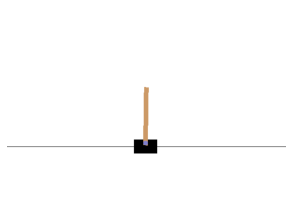

In [ ]:
# Function to plot an environment
def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    return img

plot_environment(env)
plt.show()

In [ ]:
# Functions to plot an animation
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(fig, update_scene, fargs=(frames, patch),
                                   frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

**Simple Hard-coded Policy**

Accelerates the cart left when the pole is leaning toward the left and accelerates right when the pole is leaning toward the right.

In [ ]:
# Create environment
env = gym.make("CartPole-v1")

# Create a simple policy function
def basic_policy(obs):
    ''' Returns 0 (move cart left) if angle < 0 (pole leaning left) else 1 '''
    angle = obs[2]
    return 0 if angle < 0 else 1

# Run the simple policy for 500 episodes
totals = []
for episode in range(500):
    episode_rewards = 0
    obs = env.reset()
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action)
        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)

In [ ]:
# Statistics of the total rewards from 500 episodes
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(42.796, 9.14124630452544, 24.0, 68.0)

In [ ]:
# Visualize one episode with basic policy

env = gym.make("CartPole-v1")
obs = env.reset()
frames = []
v = 0
for step in range(200):
    img = env.render(mode="rgb_array")
    frames.append(img)
    # action based on simple policy
    action = basic_policy(obs)
    obs, reward, done, info = env.step(action)
    if done and v==0:
        fell_step = step
        v += 1

print("\nFell after ", fell_step, " steps\n")        
# Visualize animation
plot_animation(frames)

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))



Fell after  50  steps



In above simulation, the cart oscillates too much. 

Let’s use neural networks to make a better policy.

**Neural Network Policy**

In [ ]:
# Create model
n_inputs = 4 # == env.observation_space.shape[0]
model = Sequential([
                    Dense(5, activation="elu", input_shape=[n_inputs]),
                    Dense(1, activation="sigmoid")
                    ])

Let's write a small function that will run the model to play one episode, and return the frames so we can display an animation:

In [ ]:
# Create function to return frames for animation
def render_policy_net(model, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1")
    env.seed(seed)
    np.random.seed(seed)
    obs = env.reset()
    for step in range(n_max_steps):
        img = env.render(mode="rgb_array")
        frames.append(img)
        left_proba = model.predict(obs.reshape(1, -1))
        action = int(np.random.rand() > left_proba)
        obs, reward, done, info = env.step(action)
        if done:
            print("Fell after ", step, " steps")
            break
        if step==n_max_steps-1:
            print("Pole didn't fell till ", n_max_steps, "steps!")
    env.close()
    return frames

Now let's look at how well this randomly initialized policy network performs:

In [ ]:
# Visualize animation
frames = render_policy_net(model)
plot_animation(frames)

Fell after  30  steps


We can see it performs pretty bad. The neural network will have to learn to do better. First, let's see if it is capable of learning the basic policy we used earlier: go left if the pole is tilting left, and go right if it is tilting right.

We can make the same network play in 50 different environments in parallel (this will give us a diverse training batch at each step), and train for 5000 iterations. We also reset environments when they are done. We train the model using a custom training loop so we can easily use the predictions at each training step to advance the environments.

In [ ]:
# Play in 50 different environments
n_environments = 50
n_iterations = 5000

envs = [gym.make("CartPole-v1") for _ in range(n_environments)]
for index, env in enumerate(envs):
    env.seed(index)
np.random.seed(42)
observations = [env.reset() for env in envs]
optimizer = keras.optimizers.RMSprop()
loss_fn = keras.losses.binary_crossentropy

for iteration in range(n_iterations):
    # if angle < 0, we want proba(left) = 1., or else proba(left) = 0.
    target_probas = np.array([([1.] if obs[2] < 0 else [0.])
                              for obs in observations])
    with tf.GradientTape() as tape:
        left_probas = model(np.array(observations))
        loss = tf.reduce_mean(loss_fn(target_probas, left_probas))
    print("\rIteration: {}, Loss: {:.3f}".format(iteration, loss.numpy()), end="")
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    actions = (np.random.rand(n_environments, 1) > left_probas.numpy()).astype(np.int32)
    for env_index, env in enumerate(envs):
        obs, reward, done, info = env.step(actions[env_index][0])
        observations[env_index] = obs if not done else env.reset()

for env in envs:
    env.close()

Iteration: 4999, Loss: 0.075

In [ ]:
# Visualize animation
frames = render_policy_net(model)
plot_animation(frames)

Fell after  65  steps


From above it seems like it learned the policy correctly. Now let's see if it can learn a better policy on its own. One that does not wobble as much.

**Policy Gradients with Neural Network**

The _Policy Gradients_ algorithm tackles ***credit assignment problem*** by first playing multiple episodes, then making the actions in good episodes slightly more likely, while actions in bad episodes are made slightly less likely.

One common variant of PG algorithms:

1. First, let the neural network policy play the game several times, and at each step, compute the gradients that would make the chosen action even more likely-but don’t apply these gradients yet.

2. Once we have run several episodes, compute each action’s advantage.

3. If an action’s advantage is positive, it means that the action was probably good, and we want to apply the gradients computed earlier to make the action even more likely to be chosen in the future. However, if the action’s advantage is negative, it means the action was probably bad, and we want to apply the opposite gradients to make this action slightly less likely in the future. The solution is simply to multiply each gradient vector by the corresponding action’s advantage.

4. Finally, compute the mean of all the resulting gradient vectors, and use it to perform a Gradient Descent step.

Let’s implement this algorithm. We will train the neural network policy we built earlier so that it learns to balance the pole on the cart. 

First, we need a function that will play one step. We will pretend for now that whatever action it takes is the right one so that we can compute the loss and its gradients (these gradients will just be saved for a while, and we will modify them later depending on how good or bad the action turned out to be):

In [ ]:
# Function explanation is given below
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, info = env.step(int(action[0, 0].numpy()))
    return obs, reward, done, grads

Let’s walk through this function:

* Within the GradientTape block, we start by calling the model,
giving it a single observation (we reshape the observation so it becomes a batch
containing a single instance, as the model expects a batch). This outputs the
probability of going left.

* Next, we sample a random float between 0 and 1, and we check whether it is
greater than left_proba. The action will be False with probability left_proba,
or True with probability 1 - left_proba. Once we cast this Boolean to a number, the action will be 0 (left) or 1 (right) with the appropriate probabilities.

* Next, we define the target probability of going left: it is 1 minus the action (cast
to a float). If the action is 0 (left), then the target probability of going left will be 1. If the action is 1 (right), then the target probability will be 0.

* Then we compute the loss using the given loss function, and we use the tape to
compute the gradient of the loss with regard to the model’s trainable variables.
Again, these gradients will be tweaked later, before we apply them, depending on
how good or bad the action turned out to be.

* Finally, we play the selected action, and we return the new observation, the
reward, whether the episode is ended or not, and the gradients that we
just computed.

Now let’s create another function that will rely on the `play_one_step()` function to play multiple episodes, returning all the rewards and gradients for each episode and each step:

In [ ]:
# Create play multiple episodes function
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

This code returns a list of reward lists (one reward list per episode, containing one reward per step), as well as a list of gradient lists (one gradient list per episode, each containing one tuple of gradients per step and each tuple containing one gradient tensor per trainable variable).

The algorithm will use the `play_multiple_episodes()` function to play the game
several times (e.g., 10 times), then it will go back and look at all the rewards, discount them, and normalize them. For that, we have couple more functions.

In [ ]:
# Create functions to sum and normalize rewards
def discount_rewards(rewards, discount_rate):
    '''Compute the sum of future discounted rewards at each step'''
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_rate
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_rate):
    '''normalize all these discounted rewards (returns) across many episodes'''
    all_discounted_rewards = [discount_rewards(rewards, discount_rate)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

In [ ]:
# Hyperparameters to run the algorithm
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_rate = 0.95

In [ ]:
# Create optimizer and loss function
optimizer = keras.optimizers.Adam(learning_rate=0.01)
loss_fn = keras.losses.binary_crossentropy

Let's build and run the training loop.

In [ ]:
# Run training loop
env = gym.make("CartPole-v1")
env.seed(42);

for iteration in range(n_iterations):
    # Play multiple episodes
    all_rewards, all_grads = play_multiple_episodes(env, n_episodes_per_update, n_max_steps, model, loss_fn)
    total_rewards = sum(map(sum, all_rewards))                     
    print("\rIteration: {}, mean rewards: {:.1f}".format(iteration, total_rewards / n_episodes_per_update), end="")
    # Normalize discounted rewards 
    all_final_rewards = discount_and_normalize_rewards(all_rewards, discount_rate)
    all_mean_grads = []
    # Compute weighted mean of gradients for every trainable variable
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean([final_reward * all_grads[episode_index][step][var_index]
                                     for episode_index, final_rewards in enumerate(all_final_rewards)
                                     for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
    # Apply gradients
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

env.close()

Iteration: 149, mean rewards: 178.1

This code will train the neural network policy, and it will successfully learn to balance the pole on the cart. The mean reward per episode will get very close to 200 which represents success.

In [ ]:
# Visualize PG algorithm animation
frames = render_policy_net(model)
plot_animation(frames)

Fell after  192  steps
